In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "postgres"  # username
password = "tictok#2020"  # password
host = "localhost"  # server IP
port = "5432"  # port no
database = "warehouse_inventory"  # Data-Base name

try:
    engine = create_engine(
        f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    )
    with engine.connect() as connection:
        print("Successfully connected to PostgreSQL Data-Base")

except Exception as exc:
    print("Error while connecting to PostgreSQL", exc)

Successfully connected to PostgreSQL Data-Base


#### Q2. How much inventory value is tied up in slow-moving or dead stock?

In [17]:
query_q2 = """
WITH
    inventory_value AS (
        SELECT
            inv.item_id,
            SUM(inv.current_stock * inv.unit_cost) AS stock_value,
            MAX(sls.sale_date) AS sale_date
        FROM
            sales sls
            JOIN inventory inv ON inv.item_id = sls.item_id
        GROUP BY
            inv.item_id
    ),
    inventory_value_status AS (
        SELECT
            item_id,
            stock_value,
            sale_date,
            CASE
                WHEN sale_date <= '2025-03-31' THEN 'slow-stock'
                ELSE 'fast-stock'
            END AS stock_status
        FROM
            inventory_value
    )
SELECT
    stock_status,
    ROUND(SUM(stock_value) / 1000000, 2) AS stock_value_mn
FROM
    inventory_value_status
GROUP BY
    stock_status;
"""

inventory_value = pd.read_sql(sql=query_q2, con=engine)
inventory_value

,stock_status,stock_value_mn
0,slow-stock,266.78
1,fast-stock,2966.17


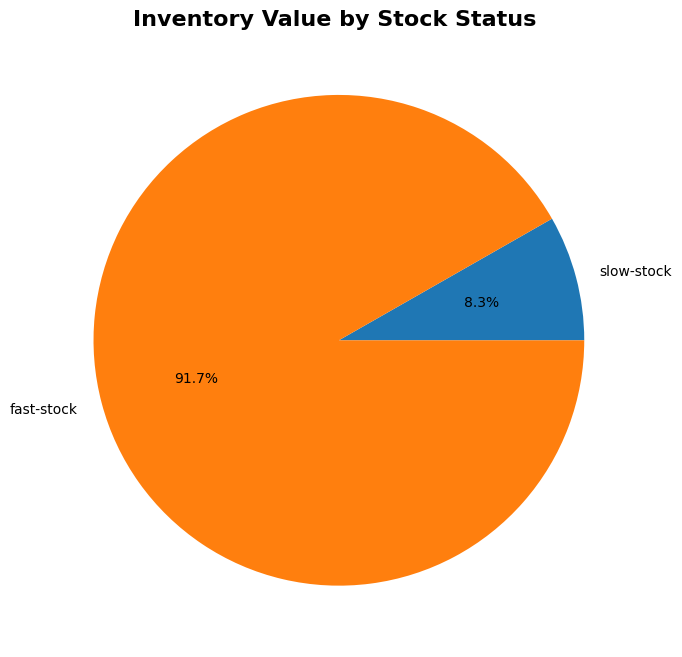

In [18]:
# Using pie chart to show the proportion of stock status in warehouse

plt.figure(figsize=(7, 7))
plt.pie(
    data=inventory_value, x="stock_value_mn", labels="stock_status", autopct="%1.1f%%"
)
plt.title("Inventory Value by Stock Status ", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

##### Insights :
1. Over 91% of stock which is fast moving, could be due to low price, essential products which is used in day to day life or popularity of the brands among the customers.
2. 8.3% stock is identified as slow moving, In this category the products are more likely to be luxury goods or seasonal. 

3. In slow moving stock we have to identify why these products stuck at the warehouse and plan inventory accordingly.